# Домашнее задание №2
## Сегментация клиентов (кластеризация).
### Сизиков Константин.

### Скачиваем данные по клиентам немецкого банка

In [59]:
!wget -O german_credit_data.csv https://raw.githubusercontent.com/spendmail/otus_machine_learning_professional_hw/master/hw_02/german_credit_data.csv

--2024-09-24 22:10:44--  https://raw.githubusercontent.com/spendmail/otus_machine_learning_professional_hw/master/hw_02/german_credit_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49689 (49K) [text/plain]
Saving to: ‘german_credit_data.csv’

german_credit_data. 100%[===================>]  48.52K  --.-KB/s    in 0.1s    

2024-09-24 22:10:45 (353 KB/s) - ‘german_credit_data.csv’ saved [49689/49689]



### Импортируем необходимые пакеты

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

np.random.seed(123)

### Загружаем данные в pandas dataframe

In [61]:
data = pd.read_csv('german_credit_data.csv')

### Проводим EDA, чтобы познакомиться с признаками

In [62]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


 - Age (numeric)
 - Sex (text: male, female)
 - Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
 - Housing (text: own, rent, or free)
 - Saving accounts (text - little, moderate, quite rich, rich)
 - Checking account (numeric, in DM - Deutsch Mark)
 - Credit amount (numeric, in DM)
 - Duration (numeric, in month)
 - Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)


### Анализируем пропуски данных

In [63]:
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

### Колонки 'Saving accounts' и 'Checking account' имеют пропуски.
Это категориальные колонки и пропусков довольно много, поэтому не будем удалять а проинициализируем нулем

In [64]:
# data = data.dropna()
data.loc[:, 'Saving accounts'] = data['Saving accounts'].fillna('0')
data.loc[:, 'Checking account'] = data['Checking account'].fillna('0')

### Анализируем уникальные значения колонок

In [65]:
data.nunique()

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        5
Checking account       4
Credit amount        921
Duration              33
Purpose                8
dtype: int64

### Если нужно выборочно

In [66]:
data['Age'].unique()

array([67, 22, 49, 45, 53, 35, 61, 28, 25, 24, 60, 32, 44, 31, 48, 26, 36,
       39, 42, 34, 63, 27, 30, 57, 33, 37, 58, 23, 29, 52, 50, 46, 51, 41,
       40, 66, 47, 56, 54, 20, 21, 38, 70, 65, 74, 68, 43, 55, 64, 75, 19,
       62, 59])

### Анализируем типы данных

In [67]:
pd.DataFrame(np.array([data.dtypes, data.iloc[0]]), columns=data.columns)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,int64,int64,object,int64,object,object,object,int64,int64,object
1,0,67,male,2,own,0,little,1169,6,radio/TV


### Преобразовываем категориальные переменные с помощью LabelEncoder 

In [68]:
label_encoder_cols = ['Sex','Housing','Saving accounts','Checking account','Purpose']
le = LabelEncoder()

for col in label_encoder_cols:
    data[col] = le.fit_transform(data[col])

### Удаляем лишние колонки

In [69]:
drop_cols = ['Unnamed: 0']
data = data.drop(drop_cols, axis=1)

### Предпросмотр результата

In [70]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,0,1,1169,6,5
1,22,0,2,1,1,2,5951,48,5
2,49,1,1,1,1,0,2096,12,3
3,45,1,2,0,1,1,7882,42,4
4,53,1,2,0,1,1,4870,24,1


In [71]:
data.describe()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,0.690000,1.904000,1.071000,1.190000,1.001000,3271.258000,20.903000,2.878000
std,11.375469,0.462725,0.653614,0.531264,0.966869,0.957034,2822.736876,12.058814,1.978138
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,250.000000,4.000000,0.000000
25%,27.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1365.500000,12.000000,1.000000
50%,33.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2319.500000,18.000000,3.000000
75%,42.000000,1.000000,2.000000,1.000000,1.000000,2.000000,3972.250000,24.000000,5.000000
max,75.000000,1.000000,3.000000,2.000000,4.000000,3.000000,18424.000000,72.000000,7.000000


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Age               1000 non-null   int64
 1   Sex               1000 non-null   int64
 2   Job               1000 non-null   int64
 3   Housing           1000 non-null   int64
 4   Saving accounts   1000 non-null   int64
 5   Checking account  1000 non-null   int64
 6   Credit amount     1000 non-null   int64
 7   Duration          1000 non-null   int64
 8   Purpose           1000 non-null   int64
dtypes: int64(9)
memory usage: 70.4 KB


### Распределение числовых признаков 

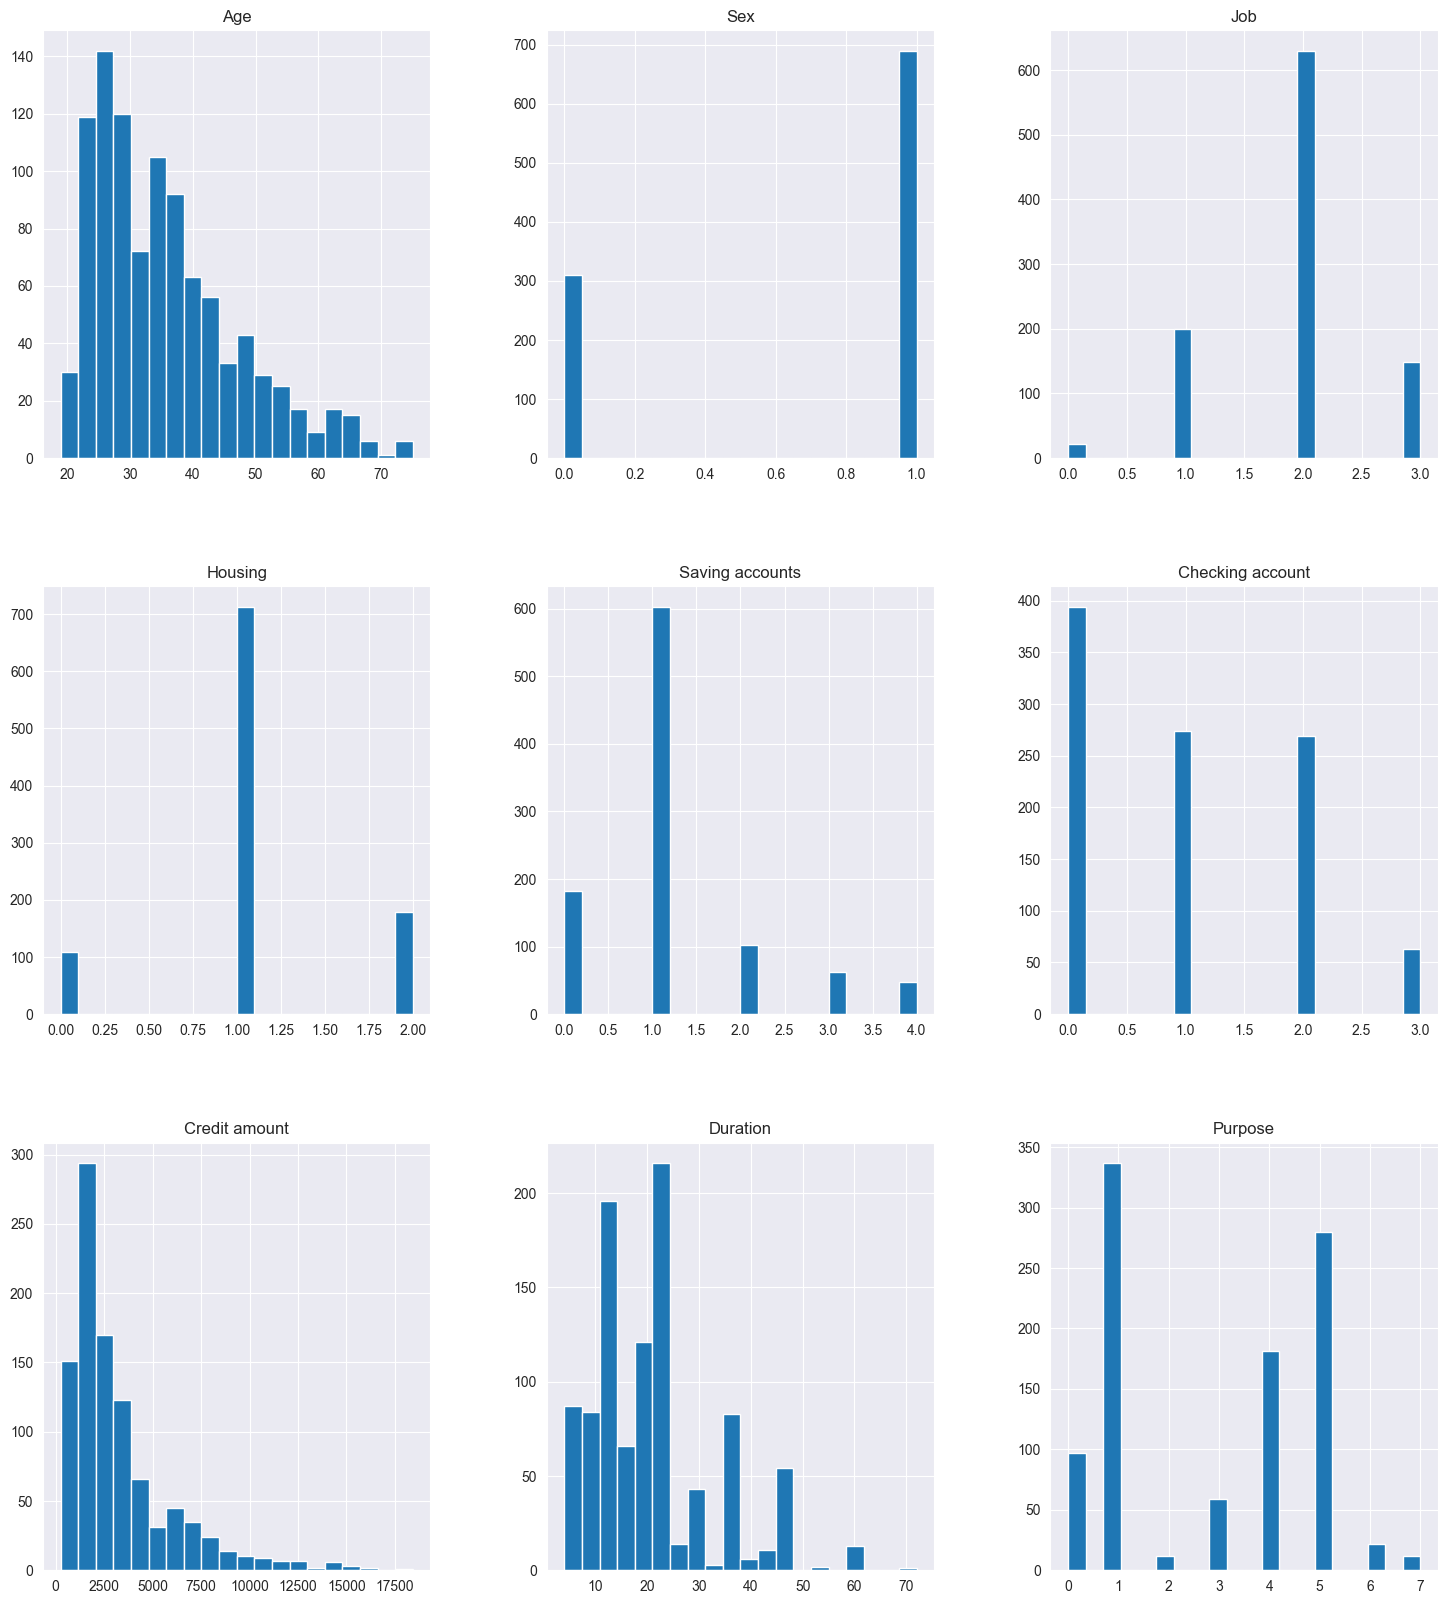

In [73]:
data.hist(figsize=(18, 20), bins=20);

### Карта корреляций

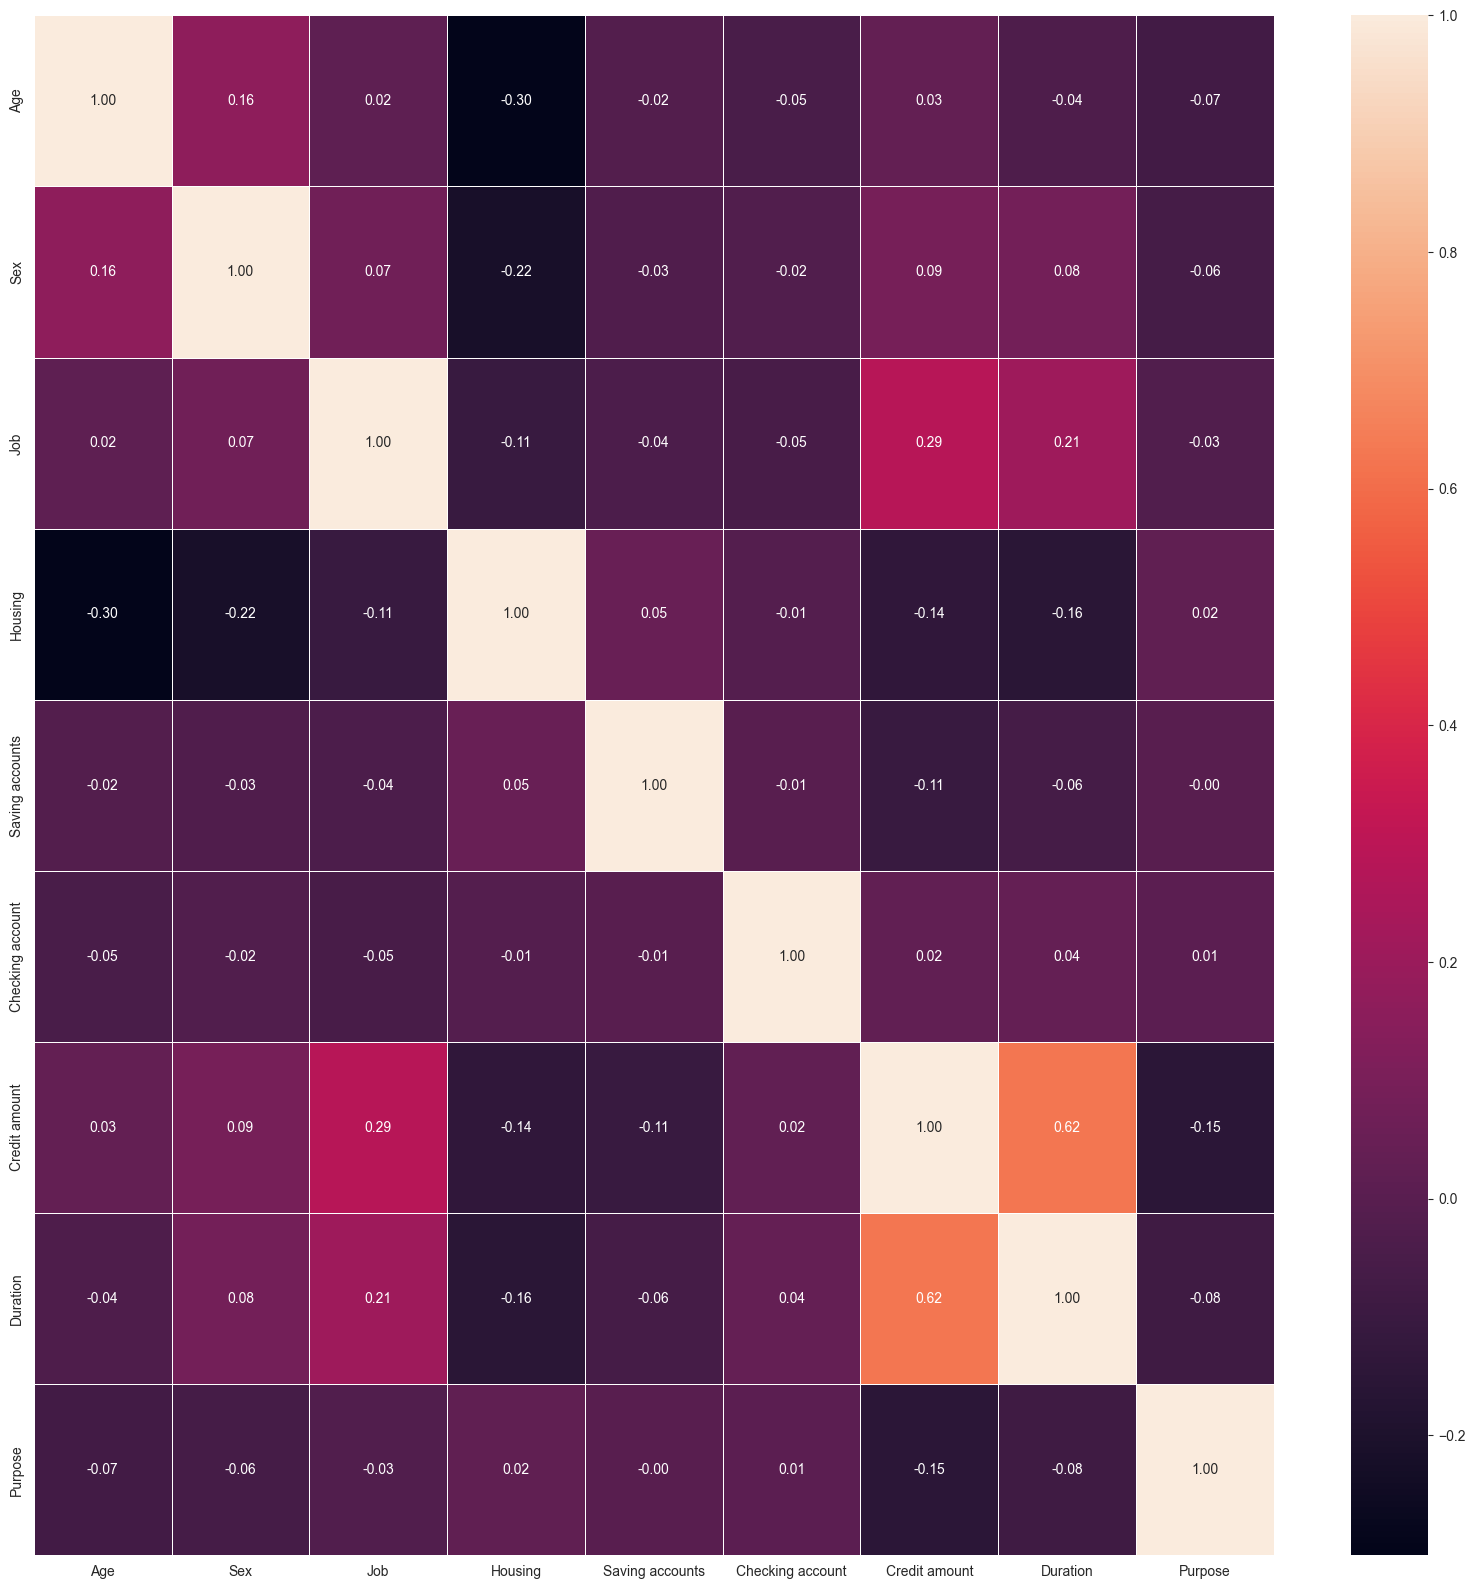

In [74]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, cbar=True, linewidths=.5, fmt='.2f')
plt.show()

### Нормализуем данные
(чтобы все компоненты давали одинаковый вклад при расчете расстояния между ними)

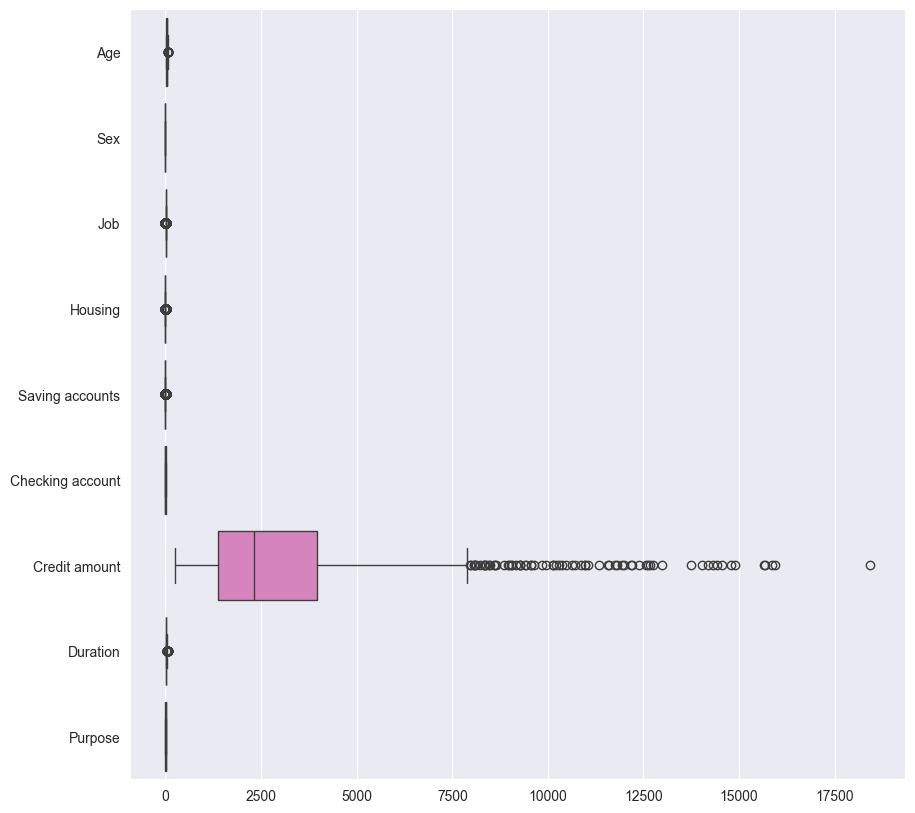

In [75]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data, orient='h');

In [76]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(X_scaled, columns=data.columns)
data_scaled.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0.857143,1.0,0.666667,0.5,0.00,0.333333,0.050567,0.029412,0.714286
1,0.053571,0.0,0.666667,0.5,0.25,0.666667,0.313690,0.647059,0.714286
2,0.535714,1.0,0.333333,0.5,0.25,0.000000,0.101574,0.117647,0.428571
3,0.464286,1.0,0.666667,0.0,0.25,0.333333,0.419941,0.558824,0.571429
4,0.607143,1.0,0.666667,0.0,0.25,0.333333,0.254209,0.294118,0.142857


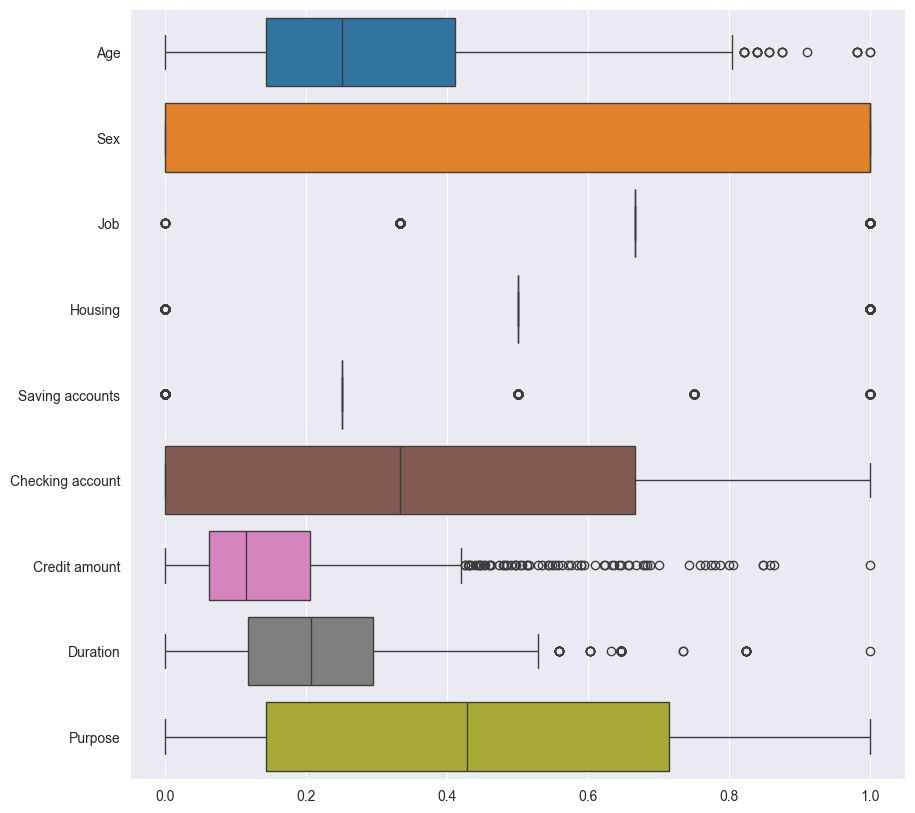

In [77]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data_scaled, orient='h');

### Снижаем размерность для визуализации
Посмотрим как выглядят данные после снижения размерности различными способами

### TSNE

In [78]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=10)
X_scaled.shape

(1000, 9)

In [79]:
X_tsne = tsne.fit_transform(X_scaled)
X_tsne.shape

(1000, 2)

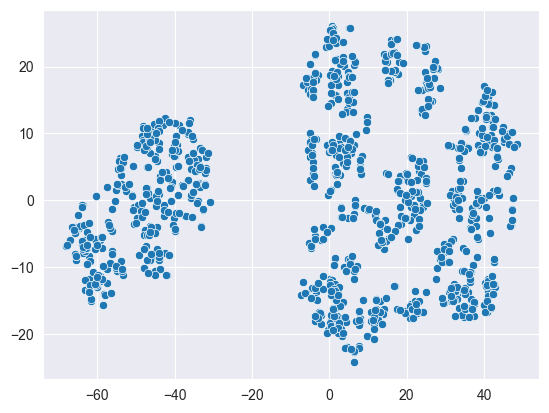

In [80]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1]);

### UMAP

In [81]:
import umap.umap_ as umap
umap = umap.UMAP(n_components=2, random_state=0)
X_umap = umap.fit_transform(X_scaled)
X_scaled.shape

(1000, 9)

In [82]:
X_umap.shape

(1000, 2)

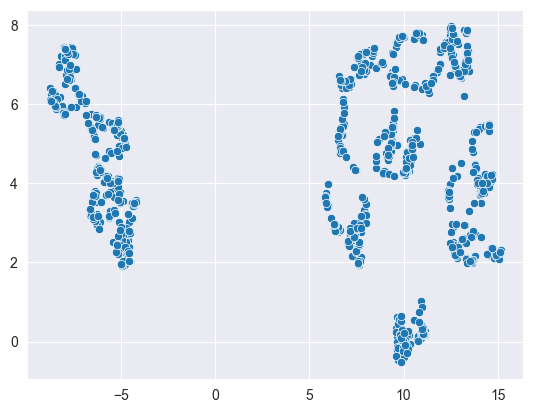

In [83]:
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1]);

### PCA

In [84]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled)
X_scaled.shape

(1000, 9)

In [85]:
X_pca.shape

(1000, 2)

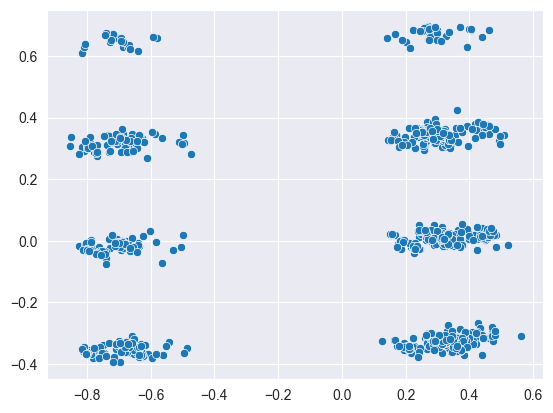

In [86]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1]);

### Кластеризация

### Hierarhical (AgglomerativeClustering)

Построим дендрограмму, чтобы посмотреть как точки объединяются между собой

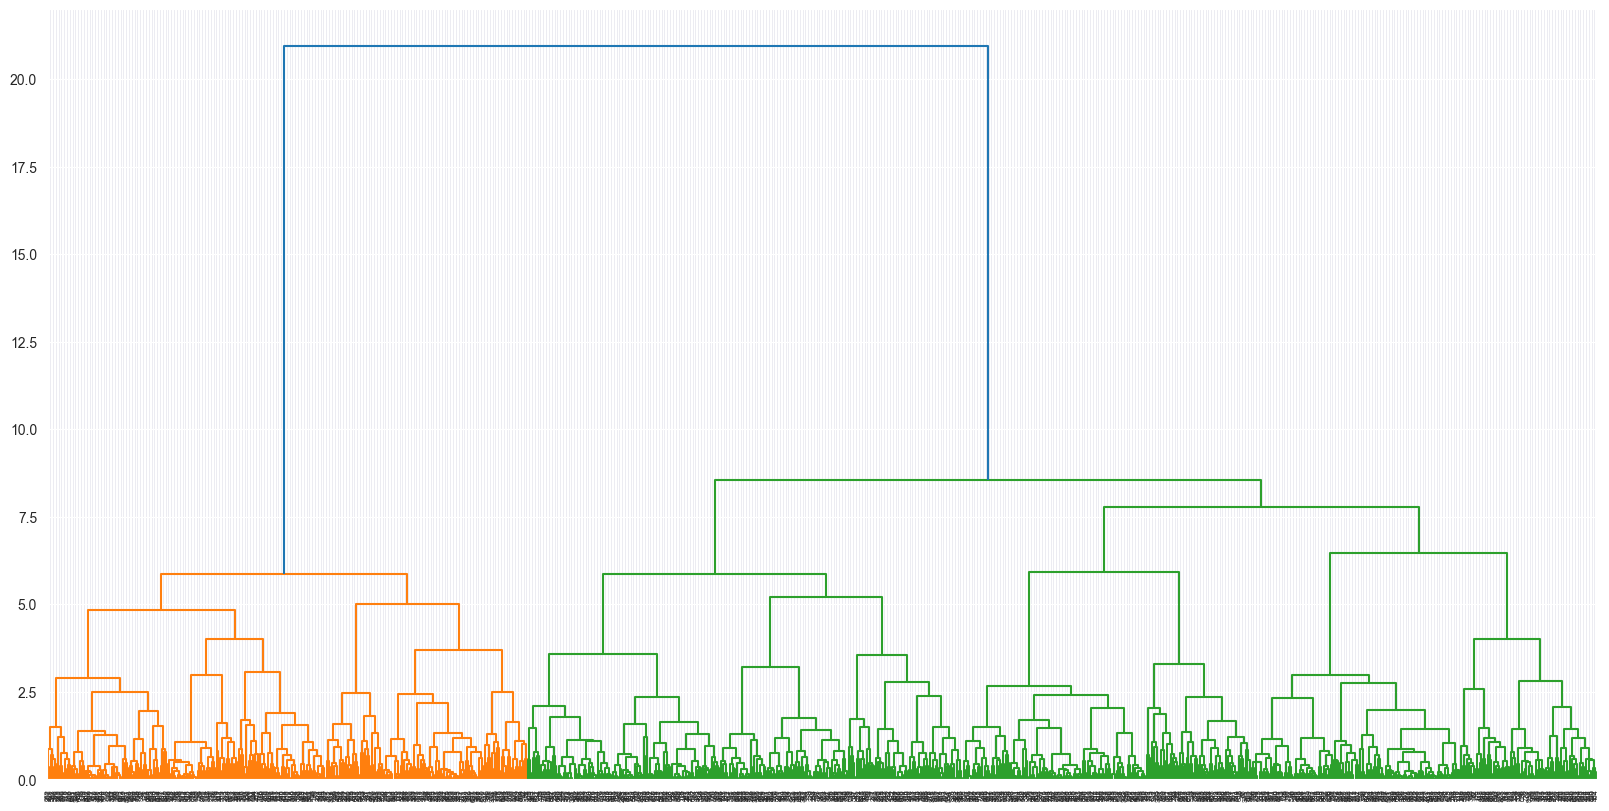

In [87]:
plt.figure(figsize=(20,10))
linkage_ = linkage(X_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

Посмотрим как меняется коэффициент "силуэт" (silhouette) в зависимости от количества кластеров

Другие доступные метрики:
- среднее межкластерное расстояние
- среденее внутрикластерное расстояние
- "точка локтя" в инерции (для K-MEANS) 

In [88]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(X_scaled)
    labels = agg.labels_
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)

100%|██████████| 9/9 [00:00<00:00, 26.72it/s]


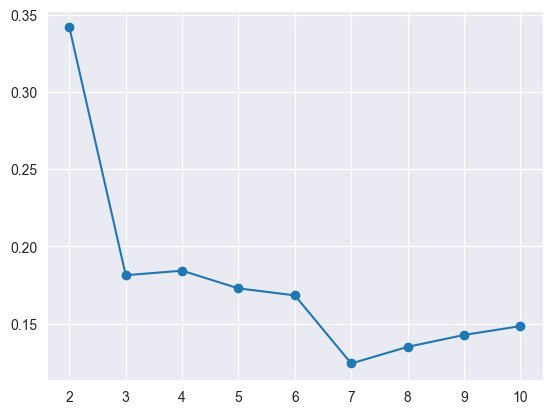

In [89]:
plt.plot(range(2,11), silhouette, marker='o');

Видим, что максимальный silhouette наблюдается при 2-х кластерах.

In [32]:
agg = AgglomerativeClustering(n_clusters=2).fit(X_scaled)
labels = agg.labels_

Выведем на графике 2 кластера снизив размерность с помощью TSNE 

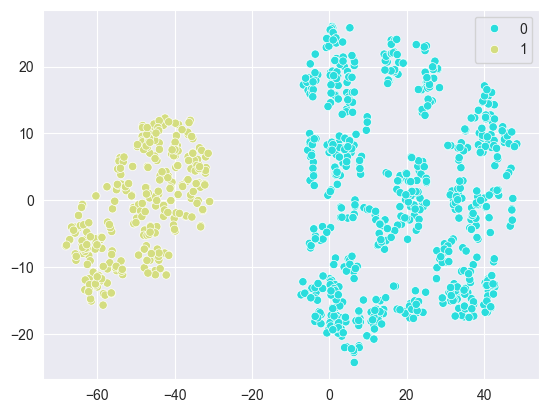

In [33]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

In [34]:
data['labels'] = labels

In [35]:
data['labels'].value_counts(normalize=True)

labels
0    0.69
1    0.31
Name: proportion, dtype: float64

Посмотрим как разделились признаки по 2-м кластерам

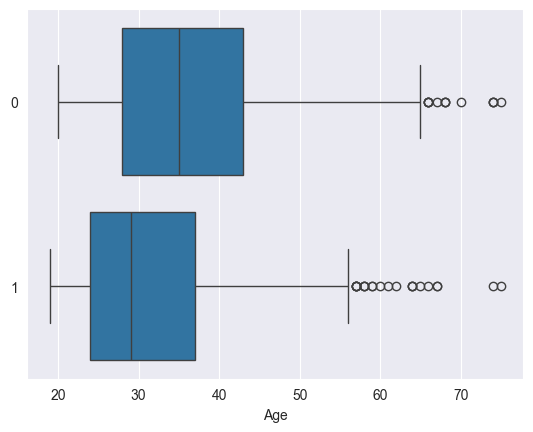

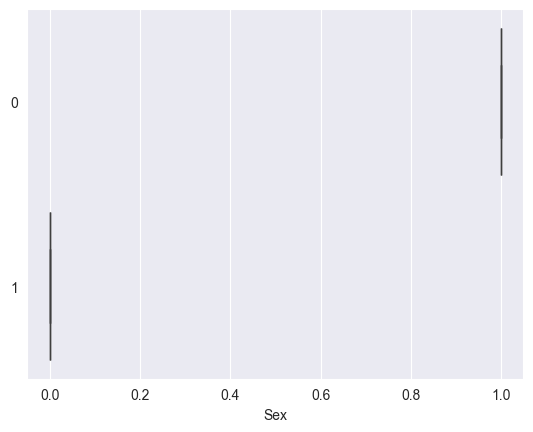

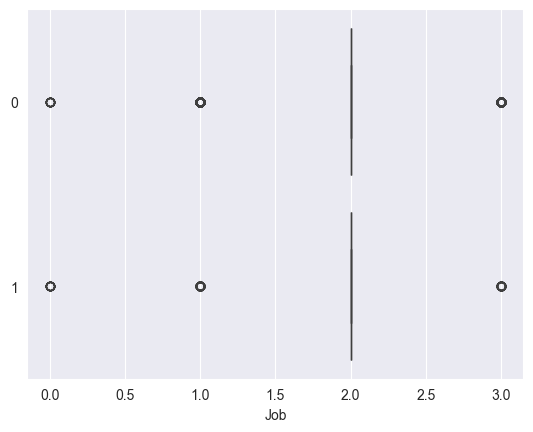

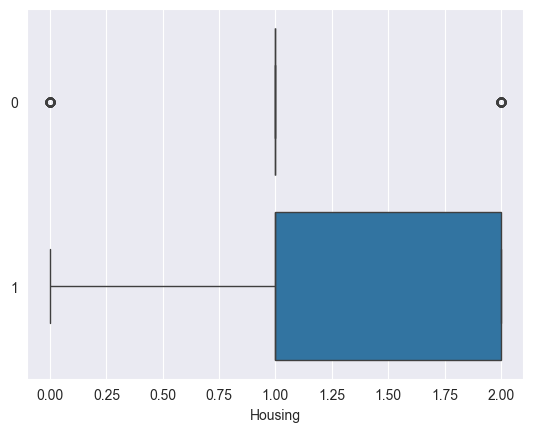

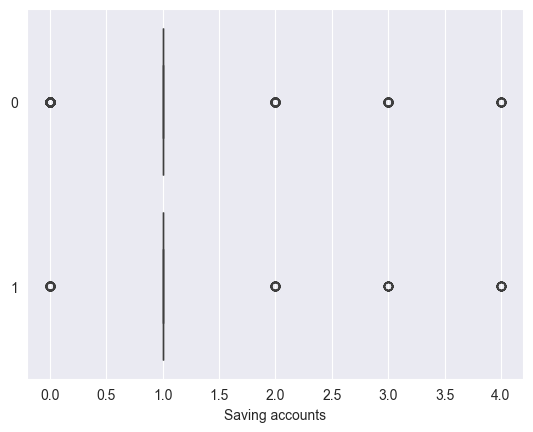

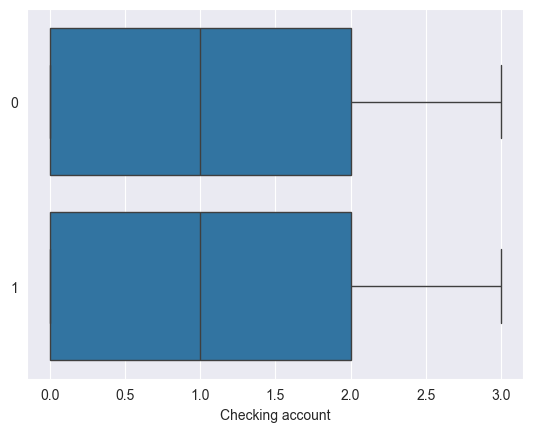

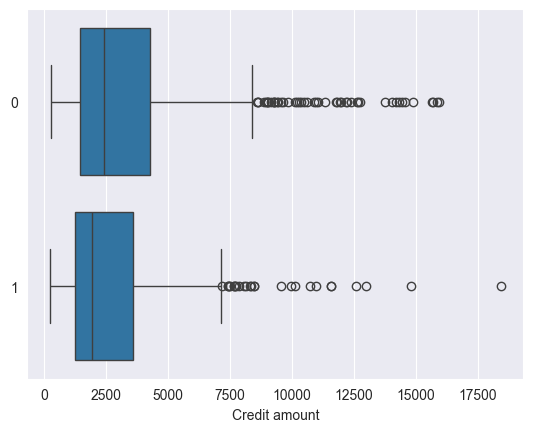

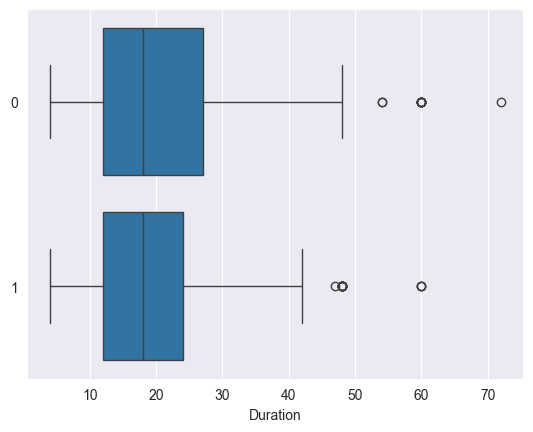

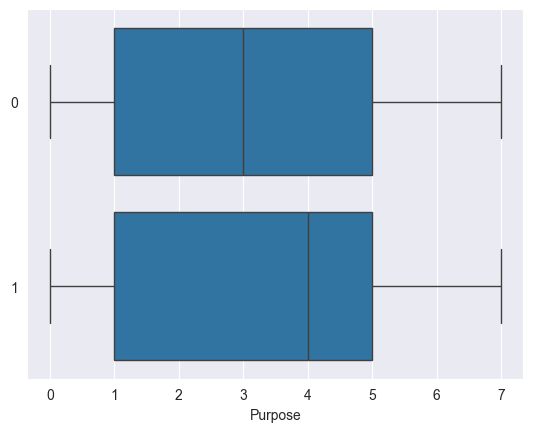

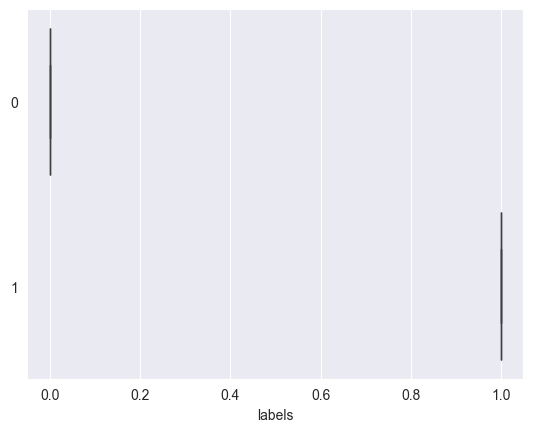

In [36]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();    

In [37]:
data.groupby('labels').median().T.round(2)

labels,0,1
Age,35.0,29.0
Sex,1.0,0.0
Job,2.0,2.0
Housing,1.0,1.0
Saving accounts,1.0,1.0
Checking account,1.0,1.0
Credit amount,2443.5,1959.0
Duration,18.0,18.0
Purpose,3.0,4.0


Видим разделение по полу, возрасту, сумме кредита и цели кредита. 

### DBSCAN

In [38]:
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

Посмотрим как меняется число кластеров и "silhouette" в зависимости от эпсилан

100%|██████████| 90/90 [00:03<00:00, 27.14it/s]


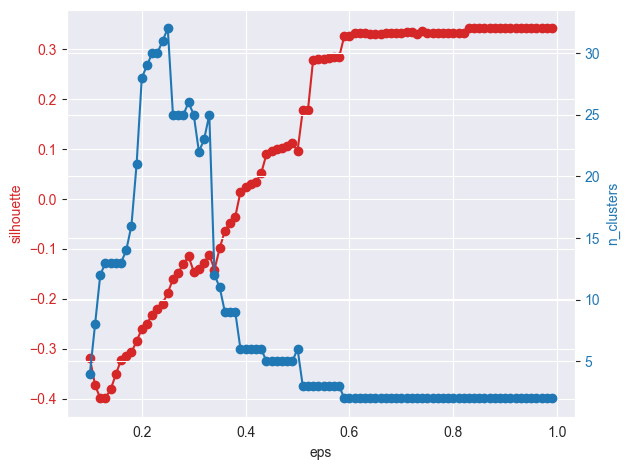

In [39]:
eps_range = np.arange(0.1,1,0.01)
dbscan_clustering(eps_range, X_scaled)

Теперь увеличим масштаб в интересующем нас месте

100%|██████████| 20/20 [00:01<00:00, 17.24it/s]


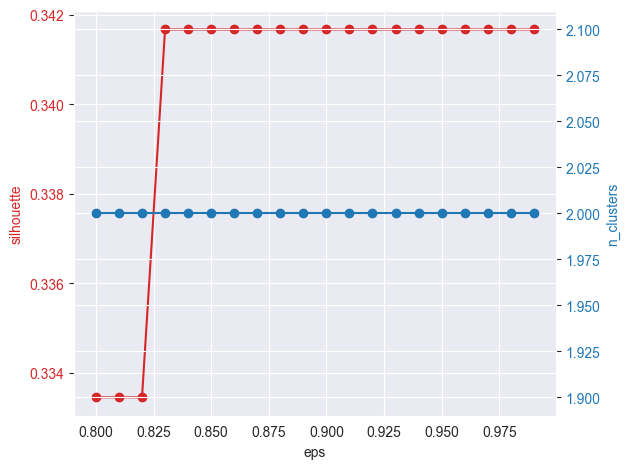

In [40]:
eps_range = np.arange(0.8,1,0.01)
dbscan_clustering(eps_range, X_scaled)

Оптимальный вариант при максимальном silhouette и 2-х кластерах eps = 0.85 

In [41]:
dbscan = DBSCAN(eps=0.85).fit(X_scaled)
labels = dbscan.labels_

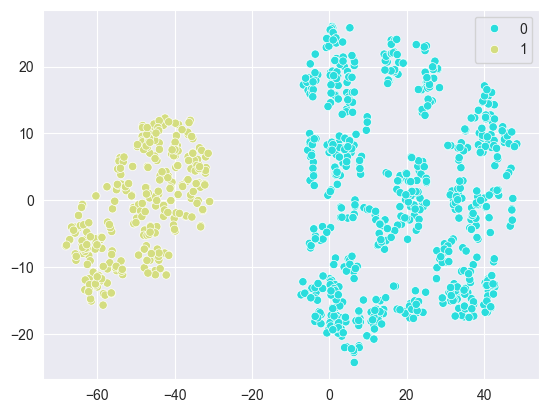

In [42]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

Датасат разделился на 2 кластера без аномалий

In [43]:
data['labels'] = labels

In [44]:
data['labels'].value_counts(normalize=True)

labels
0    0.69
1    0.31
Name: proportion, dtype: float64

Посмотрим как варьируются различные характеристики

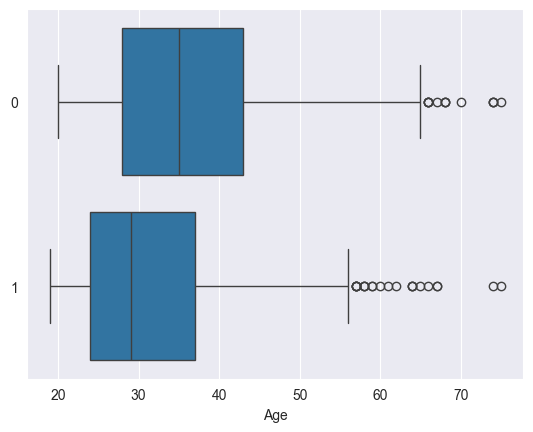

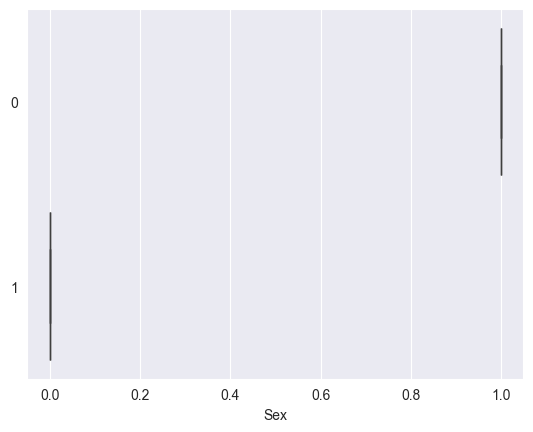

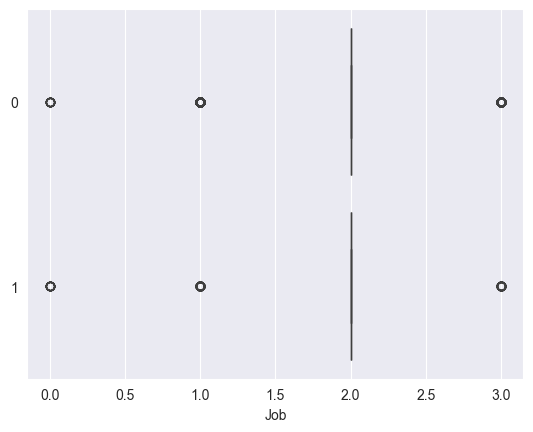

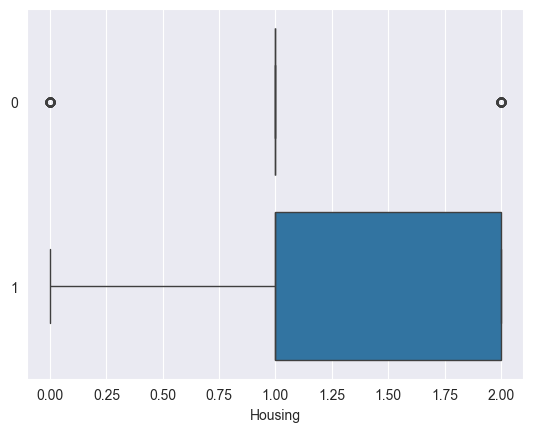

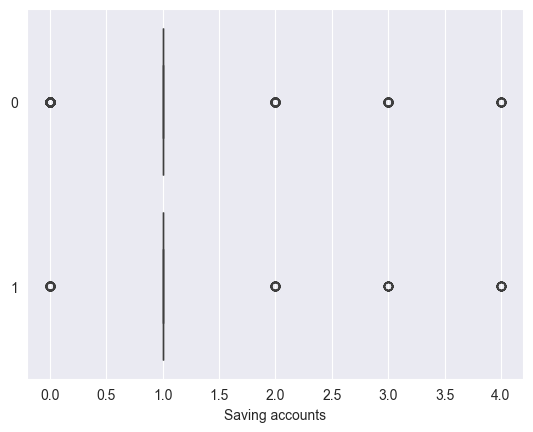

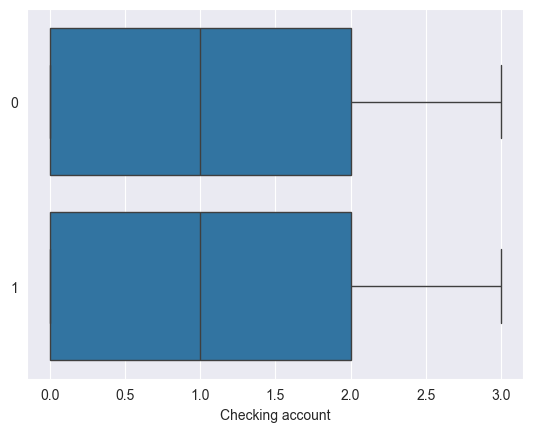

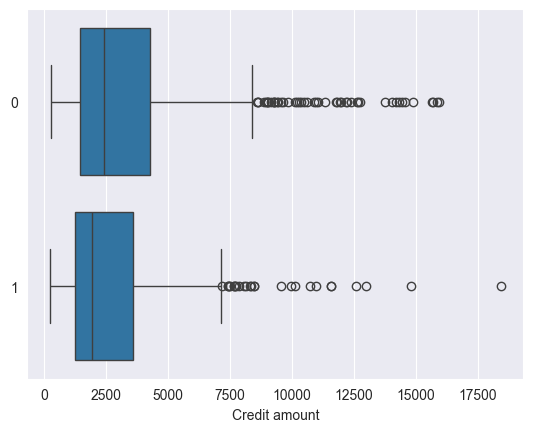

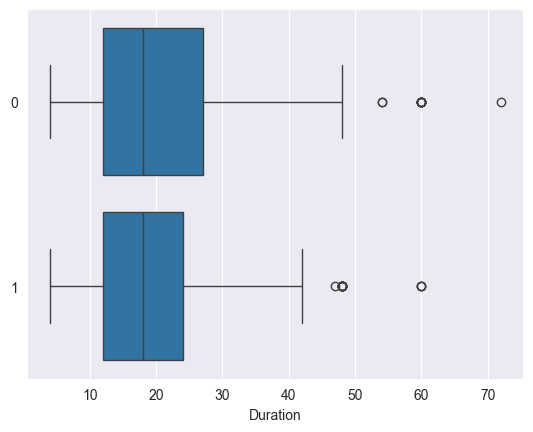

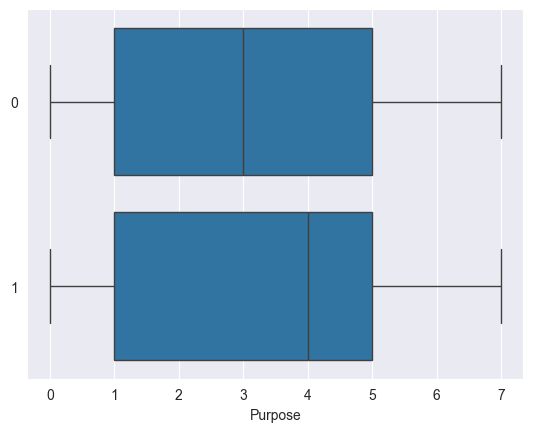

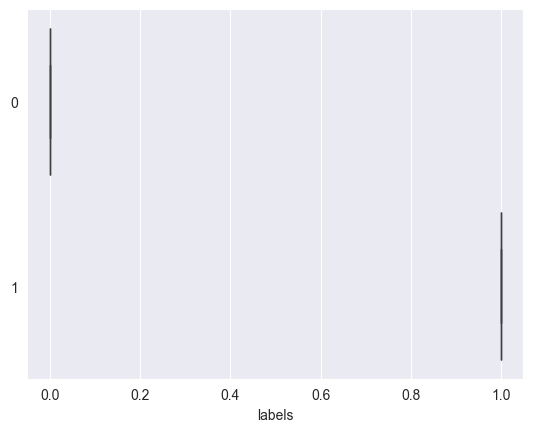

In [45]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();

In [46]:
data.groupby('labels').median().T.round(2)

labels,0,1
Age,35.0,29.0
Sex,1.0,0.0
Job,2.0,2.0
Housing,1.0,1.0
Saving accounts,1.0,1.0
Checking account,1.0,1.0
Credit amount,2443.5,1959.0
Duration,18.0,18.0
Purpose,3.0,4.0


Как и в случае с AgglomerativeClustering имеем разделение по полу, возрасту, цели и размеру кредита.

### K-MEANS

Для K-MEANS будем ориентироваться на "точку локтя" инерции 

In [47]:
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=10, n_init=10).fit(X_scaled)
    labels = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

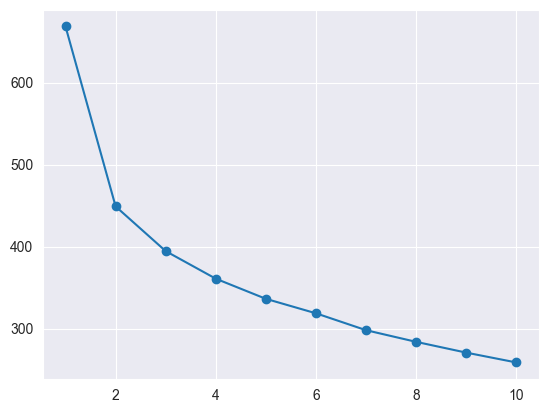

In [48]:
plt.plot(range(1,11), inertia, marker='o');

Поскольку "точка локтя" не очевидна, посмотрим также на изменение инерции

In [49]:
D = []
for i in range(1,9):
    Di = (inertia[i] - inertia[i+1])/(inertia[i-1] - inertia[i])
    D.append(Di)

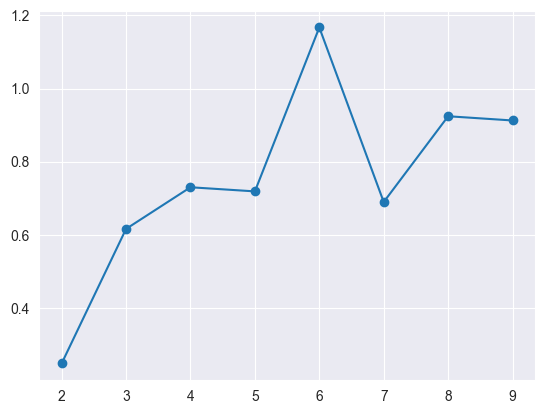

In [50]:
plt.plot(range(2,10), D, marker='o');

Видим, что минимум на графике изменения инерции находится в точке, с количеством кластеров = 2

In [51]:
kmeans = KMeans(n_clusters=2, random_state=10, n_init=10).fit(X_scaled)
labels = kmeans.labels_

Отрисуем точки на графике, на этот раз использую метод снижения размерности UMAP

<Axes: >

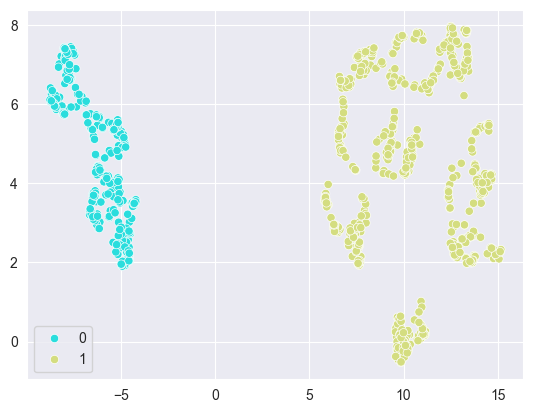

In [52]:
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette='rainbow')

In [53]:
data_scaled['labels'] = labels
data['labels'] = labels
data['labels'].value_counts(normalize=True)

labels
1    0.69
0    0.31
Name: proportion, dtype: float64

Имеем 2 кластера в процентном соотношении 69% к 31%

In [54]:
data.tail()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,labels
995,31,0,1,1,1,0,1736,12,4,0
996,40,1,3,1,1,1,3857,30,1,1
997,38,1,2,1,1,0,804,12,5,1
998,23,1,2,0,1,1,1845,45,5,1
999,27,1,2,1,2,2,4576,45,1,1


In [55]:
data['labels'].value_counts(normalize=True).sort_index()

labels
0    0.31
1    0.69
Name: proportion, dtype: float64

In [56]:
X_scaled

array([[0.85714286, 1.        , 0.66666667, ..., 0.05056674, 0.02941176,
        0.71428571],
       [0.05357143, 0.        , 0.66666667, ..., 0.31368989, 0.64705882,
        0.71428571],
       [0.53571429, 1.        , 0.33333333, ..., 0.10157368, 0.11764706,
        0.42857143],
       ...,
       [0.33928571, 1.        , 0.66666667, ..., 0.03048311, 0.11764706,
        0.71428571],
       [0.07142857, 1.        , 0.66666667, ..., 0.08776274, 0.60294118,
        0.71428571],
       [0.14285714, 1.        , 0.66666667, ..., 0.23803235, 0.60294118,
        0.14285714]])

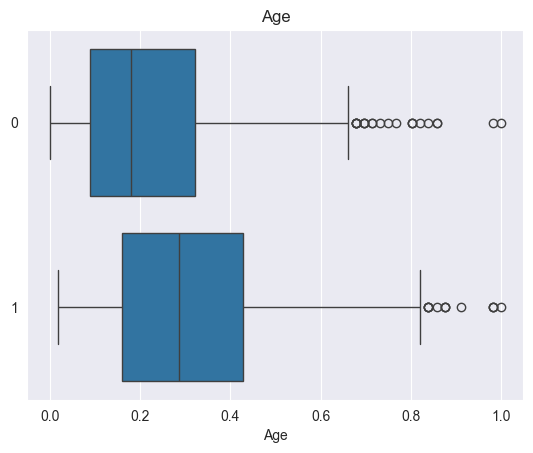

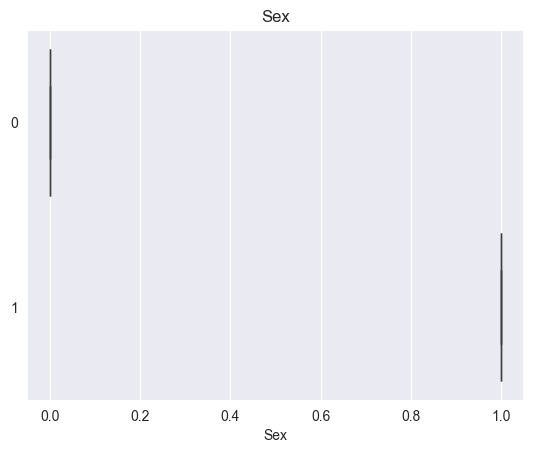

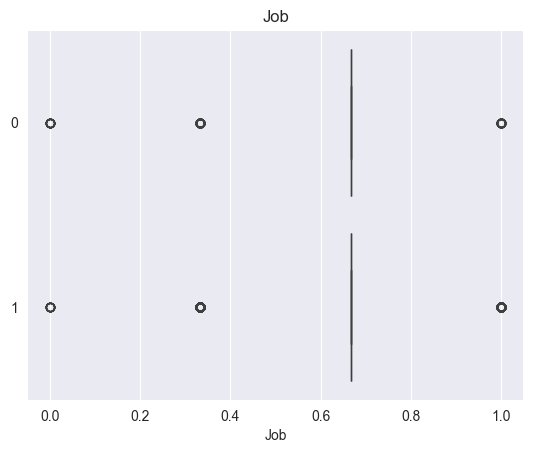

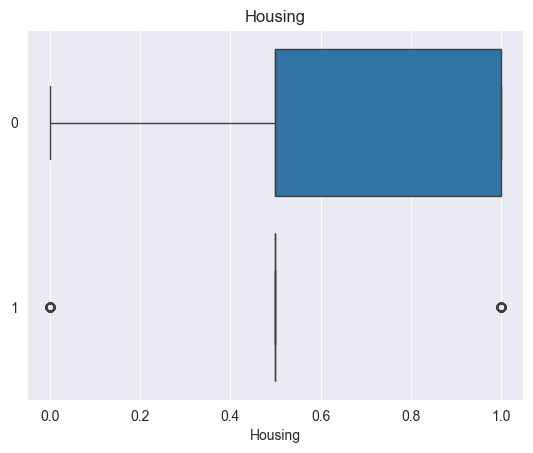

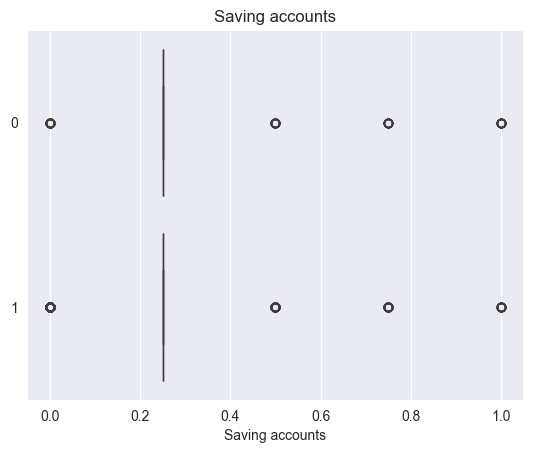

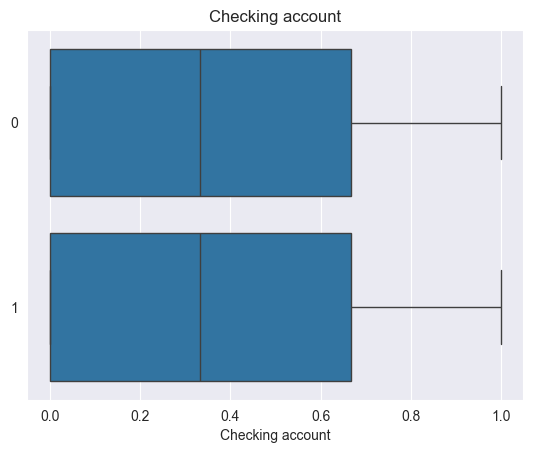

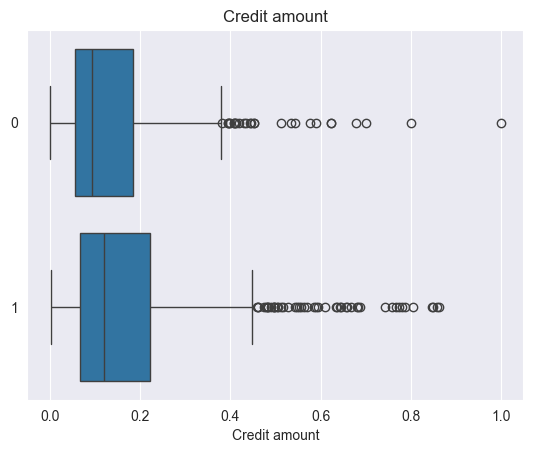

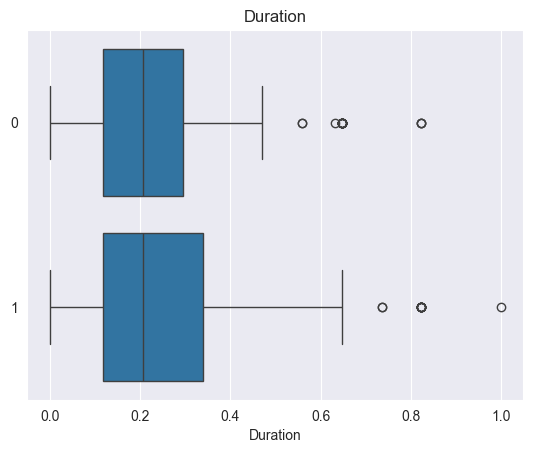

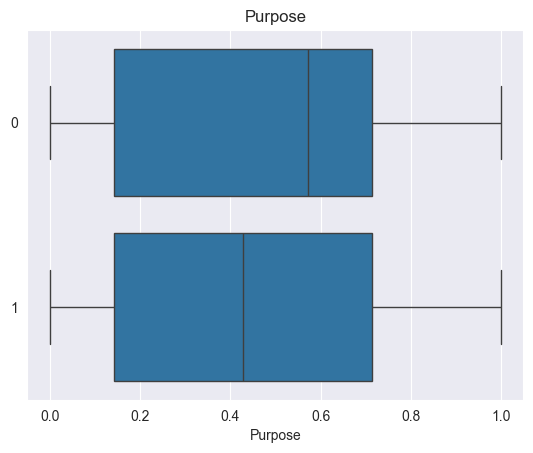

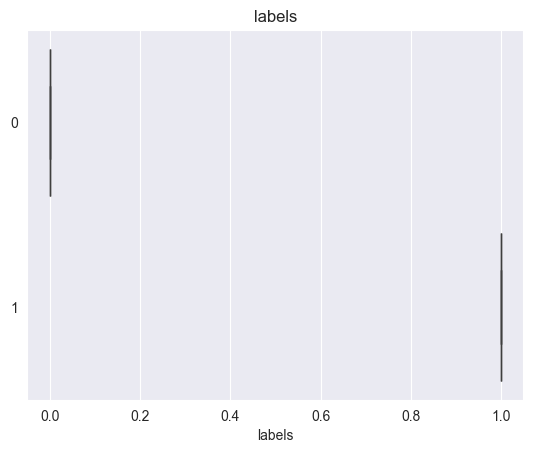

In [57]:
for col in data_scaled.columns:
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h')
    plt.title(col)
    plt.show();

In [58]:
data_scaled.groupby('labels').median().T.round(2)

labels,0,1
Age,0.18,0.29
Sex,0.00,1.00
Job,0.67,0.67
Housing,0.50,0.50
Saving accounts,0.25,0.25
Checking account,0.33,0.33
Credit amount,0.09,0.12
Duration,0.21,0.21
Purpose,0.57,0.43


### Резюме

На основе 3х методов кластеризации получаем 2 группы людей:

В первой группе мужчины, средний возраст 35 лет, средний размер кредита 2443.

Во второй группе женщины, средний возраст 29 лет, средний размер кредита 1959.